In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

#from IPython.core.display import display, HTML
#display(HTML("<style>.container {width:100% !important;}</style>"))

In [2]:
# section1 で実装したものをインポート
from maze import MazeEnv, a2m
from agents import Agent
from policies import Policy, Random

# 2. 価値に基づく学習アルゴリズム
---
## 2-1. 行動価値観数 $Q(s,a)$ と貪欲な方策
方策として前節の**`Random`**でもゲームのプレイは出来ましたが、当然ムダな動きが多いので、
* 各状態 s に対して「最適」な行動 a が存在するか？

というのは自然な問いでしょう。素朴には「得られる即時報酬の総和」$\sum_t r_t$ を最大化すれば良い気がしますが、よく取られるのは適当な減衰率 0<γ<1 を導入した、時刻t からの減衰和です：

$$
g_t = \sum_{k=0}^\infty \gamma^k r_{t+1+k}
$$

これを**収益(return)**といいます。

この値を MDP の系列の各時刻で最大にするようにしたいわけですが、$g_t, r_t$は確率変数なので、このままではゲームのプレイサンプル毎に値が変動してしまいます。

そこでこれを、$P_s, P_r, \pi$の確率から成る MDP における期待値で表すことにします。

$$
Q(s, a) = \langle g_t \rangle_{(s_t, a_t)=(s,a)}
$$

これを**行動価値観数(action value function)**と言います。

意味は
* 時刻 t で状態 s の時に行動 a を取り、その後はずっと方策$\pi$でプレイし続けたときに得られる**収益**の期待値

です。$Q(s,a)$の値が今回の機械学習で推定するターゲットというわけです。そのため、学習パラメータのクラスを

In [3]:
class Parameters():
    def __init__(self, Env, init=0.01):
        self.values_table = init*np.random.rand(Env.lx*Env.ly*4).reshape(Env.lx, Env.ly, 4)
        
    def get_values(self, s):
        """
        座標＝sでの[Q(s, a=0), Q(s, a=1), Q(s, a=2), Q(s, a=3)]
                      を返す
        """
        x, y = s # state
        return self.values_table[x, y, :]

とでもしておきましょう。

$Q(s,a)$が**`Parameters`**クラスとして実装できたとしたとして、$Q$の意味を思い出してみると、方策として

$$
\pi_{greedy}(a|s)
=
\delta \Big(
a - 
\text{argmax}_{a'}\big\{ Q(s, a') \big\}
\Big)
$$

つまり、与えられた状態 s 毎に、行動価値観数が最大になる行動を取る方策を取れば良さそうです。これを**貪欲な方策(greedy policy)**と言います：

In [7]:
class Greedy(Policy):
    def __init__(self, Env, Q):
        self.Q = Q
        self.Env = Env
        
    def returns_action_from(self, values):
        action = np.argmax(values)
        return action
        
    def sample(self):
        Qvalues = self.Q.get_values(self.Env.state)
        return self.returns_action_from(Qvalues)

In [8]:
Pi = Greedy(Env=None, Q=None)
action = Pi.returns_action_from(values=[0,100,9,10])
action, a2m[action]

(1, 'down')

> **【補足】** np.argmax(リスト)は、リストに同じ値の最大値がある場合、一番添え字の若いものを選びます。

### ● ε-greedy方策
このGreedy方策を用いたMDPからのサンプリングは、$Q(s,a)$の値が正しければ良いですが、学習には不向きです。

そこでこれを修正した**ε-貪欲方策(ε-greedy policy)**：

$$
\pi_{\epsilon\text{-}greedy}(a|s)
=
\left\{ \begin{array}{ll}
\pi_{greedy}(a|s) & (\text{w/ probability}\quad 1- \epsilon) \\
\pi_{random}(a|s) & (\text{w/ probability}\quad \epsilon)\\
\end{array} \right.
$$

を使うことがあります：

In [9]:
class EpsilonGreedy(Greedy):
    def __init__(self, Env, Q, epsilon):
        super(EpsilonGreedy, self).__init__(Env, Q) # python 3 : super().__init__(Env, Q)で十分
        self.epsilon = epsilon
    
    def returns_action_from(self, values):
        if np.random.rand()<1-self.epsilon:
            action = np.argmax(values)
        else:
            action = np.random.choice(self.Env.action_space)
        return action

In [10]:
Env = MazeEnv(10,10, threshold=1.2)
q = Parameters(Env)

Pi = EpsilonGreedy(Env=Env, Q=q, epsilon=0.8)
a = Pi.returns_action_from(values=[0,100,9,10])
a, a2m[a]

(1, 'down')

この**`q=Parameters(Env)`**を$Q(s,a) = \langle \sum_{k=0}^\infty \gamma^k r_{t+1+k} \rangle$
に設定して迷路を解けるようにしたいわけですが、これを直接計算せず、ゲームプレイの経験から推定することを考えます。

### ● 設計思想
ここからは
```
q = Parameters(Env)
Agt = Agent(Policy=EpsilonGreedy(Env, Q=q))
Opt = Optimizer(Agt)
...
Opt.update()
```
でエージェント内部のパラメータをアップデート（学習）していきたいわけですので、

In [11]:
class Optimizer():
    def __init__(self, Agt):
        self.Agt = Agt
    
    def update(self):
        """
        なんかいい感じの処理
        """
        pass

の実装を考えていきます。

---
## 2-2. ベルマン方程式とSARSA

### ● ベルマン方程式
それを達成するために、$Q(s,q)$ がある漸化式を満たすことを示しましょう：

$$
\left. \begin{array}{ll}
Q(s, a) 
&=
\langle \underbrace{g_t}_\text{substitute def} \rangle_{(s_t, a_t)=(s,a)}
\\&=
\langle \underbrace{r_{t+1}}_{=:r_\text{next}} + \underbrace{\gamma r_{t+2} + \gamma^2 r_{t+3} + \cdots}_{\gamma g_{t+1}} \rangle_{(s_t, a_t)=(s,a)}
\\&=
\underbrace{ \langle r_\text{next} \rangle_{(s_t, a_t)=(s,a)} }_\text{only depends on $t$-th time evolution}
+
\gamma
\underbrace{\langle g_{t+1} \rangle_{(s_t, a_t)=(s,a)}}_{
\big\langle
\langle g_{t+1} \rangle_{(s_{t+1}, a_{t+1})=(s_\text{next}, a_\text{next})}
\big \rangle_{s_\text{next} \sim P_s(\cdot|s, a),\ a_\text{next} \sim \pi(\cdot | s_\text{next})}
}
\\&=
\langle r_\text{next} \rangle_{s_\text{next} \sim P_s(\cdot|s, a),\ r_\text{next} \sim P_r(\cdot|s, a, s_\text{next})}
+ \gamma \big\langle
\underbrace{\langle g_{t+1} \rangle_{(s_{t+1}, a_{t+1})=(s_\text{next}, a_\text{next})}}_{Q(s_\text{next}, a_\text{next})}
\big \rangle_{s_\text{next} \sim P_s(\cdot|s, a),\ a_\text{next} \sim \pi(\cdot | s_\text{next})}
\\&=
\langle r_\text{next} \rangle_{s_\text{next} \sim P_s(\cdot|s, a),\ r_\text{next} \sim P_r(\cdot|s, a, s_\text{next})}
+ \gamma \langle
Q(s_\text{next}, a_\text{next})
\rangle_{s_\text{next} \sim P_s(\cdot|s, a),\ a_\text{next} \sim \pi(\cdot | s_\text{next})}
\end{array} \right.
$$

これを**ベルマン方程式(Bellman equation)**と言います。

> **【補足】** ここでは時間$t$は離散ですが、これを連続に拡張したほうが良い場合もあるでしょう（例えば実世界で動くエージェントの強化学習など）。連続時間への拡張は**ハミルトン-ヤコビ-ベルマン方程式(Hamilton-Jacobi-Bellman equation)**と呼ばれます。名前からわかるように古典力学におけるハミルトン-ヤコビ方程式の拡張になっているそうです。

### ● SARSA
ベルマン方程式の近似として、MDPのサンプル系列

$$
\left. \begin{array}{l:ll:ll:ll}
\dots
&
s
&
\overset{\pi(\cdot|s)}{\to}
a
\overset{P_s(\cdot|s, a)}{\to} 
&
s_\text{next}
&
\overset{\pi(\cdot|s_\text{next})}{\to}
a_\text{next}
\overset{P_s(\cdot|s_\text{next}, a_\text{next})}{\to} 
&
 \cdots
\\
&
&&
\downarrow_{P_r(\cdot|s, a, s_\text{next})} 
\\
&
-
&
&
r_\text{next}
\end{array} \right.
$$

のとき、

$$
Q(s, a) = r_\text{next} + \gamma Q(s_\text{next}, a_\text{next})
$$

としても良さそうです。つまり$q(s,a)$をモデルとして「誤差関数」

$$
l(q) = \frac{1}{2} \sum_{(s,a,r_\text{next},s_\text{next},a_\text{next}) \in MDP}\Big(q(s,a) - \big[ r_\text{next} + \gamma q(s_\text{next}, a_\text{next}) \big] \Big)^2
$$

を減らせば良さそうです。ニューラルネットの学習よろしく、勾配法でアップデートすることにすれば

$$
\left. \begin{array}{ll}
q(s,a) &\leftarrow 
q(s,a) - \eta \nabla_{q(s,a)} l(q)
\\
&= 
q(s,a) - \eta \underbrace{ \Big(q(s,a) - \big[ r_\text{next} + \gamma q(s_\text{next}, a_\text{next}) \big] \Big)}_\text{TD error}
\end{array} \right.
$$

を実際のMDPでのサンプル毎に更新すればよいでしょう。
更新する分の部分を**Temporal Difference error(TD error)**と言います。
TD errorの部分に順に$s, a, r_\text{next}, s_\text{next}, a_\text{next}$が出てきていることから、この方法を**SARSA**といいます。

In [53]:
class SARSA_optimizer(Optimizer):
    def __init__(self, Agt, eta, gamma):
        self.Agent = Agt
        self.Q = Agt.Policy.Q
        self.eta = eta
        self.gamma = gamma

    def update(self, s, a, r_next, s_next):
        a_next = self.Agent.play() # 一回プレイさせてa_nextをサンプル
        TD_error = self.Q.get_values(s)[a] - (r_next + 
                                              self.gamma*self.Q.get_values(s_next)[a_next])
        self.Q.get_values(s)[a] -= self.eta*TD_error

早速これで強化学習させてみます：

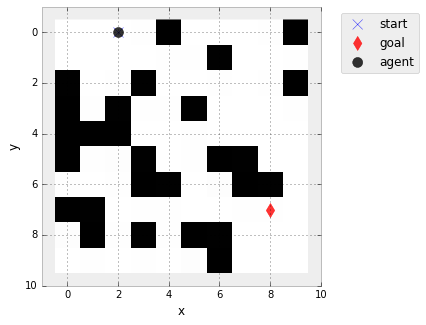

In [77]:
%matplotlib inline
Env = MazeEnv(10,10, threshold=1.2)
Env.reset()
Env.render()

In [78]:
%%time
q = Parameters(Env, init=0.00001)
Agt = Agent(Policy=EpsilonGreedy(Env, Q=q, epsilon=0.1))
Opt = SARSA_optimizer(Agt, eta=1., gamma=0.2)

for episode in range(300):
    Env.reset()
    while not Env.is_solved():
        s = Env.get_state()
        a = Agt.play()
        s_next, r_next, _, _ = Env.step(a)
        Opt.update(s, a, r_next, s_next)
    if episode%100==0:
        print('episode {} finished'.format(episode))

episode 0 finished
episode 100 finished
episode 200 finished
CPU times: user 896 ms, sys: 175 ms, total: 1.07 s
Wall time: 921 ms


学習後のエージェントで迷路を解かせてみます：

<IPython.core.display.Javascript object>


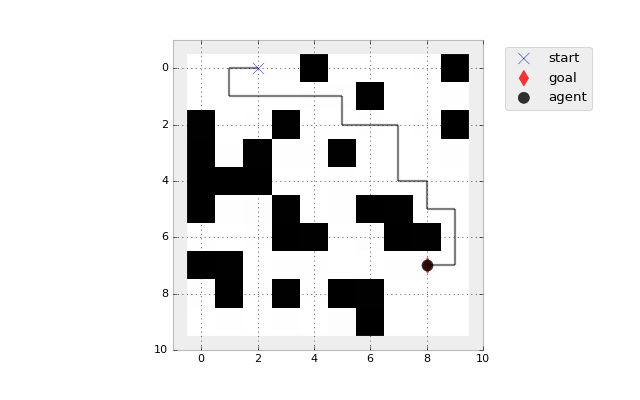

solved!


In [79]:
Env.reset()
%matplotlib notebook 
Env.play_interactive(Agt)
%matplotlib inline

### ● 探索と利用のトレードオフ
ところで、ε-greedyではなく、greedy方策で学習させると何が起こるでしょうか：

In [82]:
%%time
q = Parameters(Env, init=0.00001)
##### --- changed bagin
Agt = Agent(Policy=Greedy(Env, Q=q))
##### changed end ---
Opt = SARSA_optimizer(Agt, eta=1., gamma=0.2)

for episode in range(300):
    Env.reset()
    while not Env.is_solved():
        s = Env.get_state()
        a = Agt.play()
        s_next, r_next, _, _ = Env.step(a)
        Opt.update(s, a, r_next, s_next)
    if episode%100==0:
        print('episode {} finished'.format(episode))

episode 0 finished
episode 100 finished
episode 200 finished
CPU times: user 515 ms, sys: 96.2 ms, total: 611 ms
Wall time: 530 ms


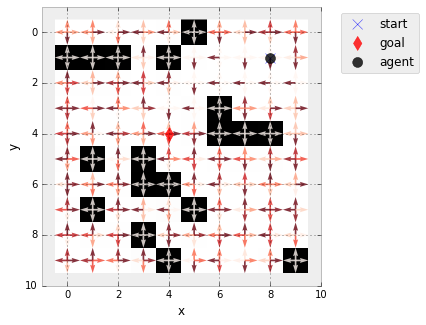

In [75]:
#q = Parameters(Env, init=0.00001)
Env.reset()
#Env.figsize=10
Env.render(values_table=q.values_table)

<IPython.core.display.Javascript object>


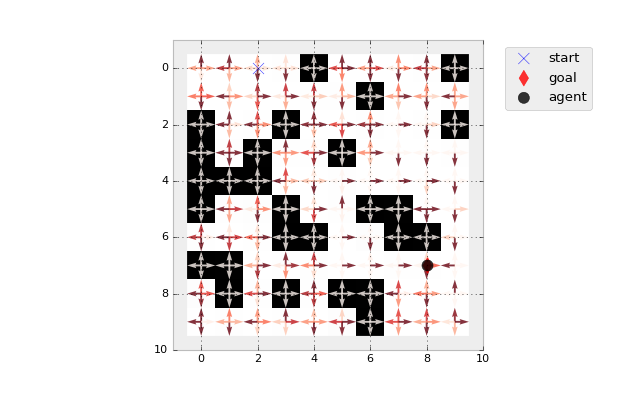

In [83]:
q = Parameters(Env, init=0.00001)
Agt = Agent(Policy=EpsilonGreedy(Env, Q=q, epsilon=0.1))
#Agt = Agent(Policy=Greedy(Env, Q=q))
Opt = SARSA_optimizer(Agt, eta=1., gamma=0.2)

##### --- added begin
%matplotlib notebook 
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.set_xlabel('x')
ax.set_ylabel('y')
##### added end ---

for episode in range(30):
    Env.reset()
    while not Env.is_solved():
        s = Env.get_state()
        a = Agt.play()
        s_next, r_next, _, _ = Env.step(a)
        Opt.update(s, a, r_next, s_next)
##### --- added begin
        Env.render(fig=fig, ax=ax, values_table=q.values_table)
        
%matplotlib inline
##### added end ---

## 2-3. Q学習
